<a href="https://colab.research.google.com/github/pavan-areti/Deep-Learning/blob/main/CIFAR10_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
train_data=datasets.CIFAR10('cifardata',train=True,download=True,transform=transform_train)
test_data=datasets.CIFAR10('cifardata',train=False,download=True,transform=transform_test)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifardata/cifar-10-python.tar.gz to cifardata
Files already downloaded and verified


In [4]:
batch_size=50
valid_size=0.2
train_length = len(train_data)
indices=list(range(len(train_data)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

train_dl=DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
val_dl=DataLoader(train_data,batch_size=batch_size,sampler=validation_sampler)
test_dl=DataLoader(test_data,shuffle=True,batch_size=batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


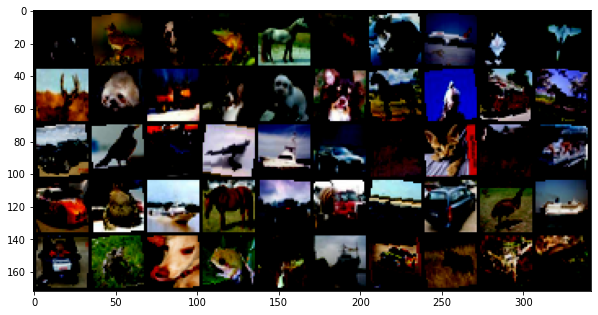

In [5]:
def show_preview(dl):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    for images,labels in dl:
        fig,ax = plt.subplots(figsize = (10,10))
        ax.imshow(make_grid(images,10).permute(1,2,0))
        break;
show_preview(train_dl)        

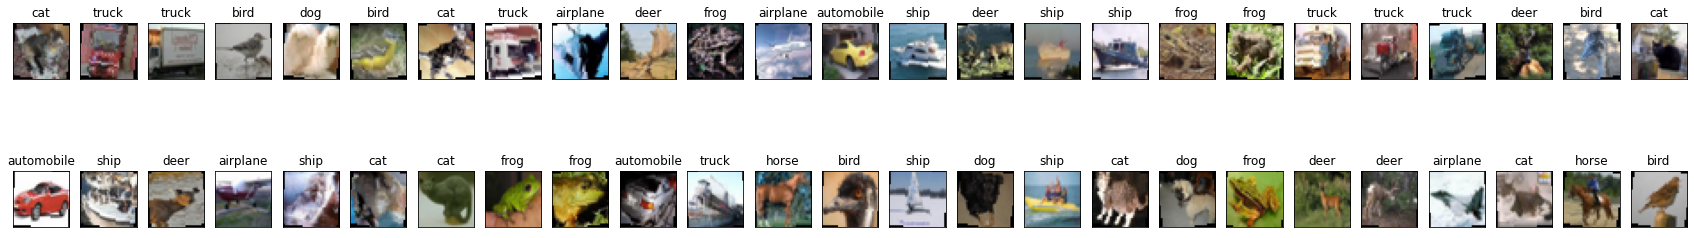

In [6]:
dataiter=iter(train_dl)
images,labels=dataiter.next()
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(batch_size):
    ax=fig.add_subplot(2,batch_size/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [7]:
######### network architecture ##############
### i am using Resnet architecture ##########

def conv_block(in_channels,out_channels,pool = False):
    layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
             ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Flatten(nn.Module):
    def forward(self, input):
        print(type(input))
        return input.view(input.size(0), -1)

class Resnet(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels,64)
        self.conv2 = conv_block(64,128,pool=True)
        self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3 = conv_block(128,256,pool=True)
        self.conv4 = conv_block(256,512,pool=True)
        self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes)
                                       )
 

    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out)+out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)+out
        return self.classifier(out)

In [8]:
model = Resnet(3,10)    

In [9]:
######## Training ########


epochs = 5
max_lr = 1e-2
criterion=nn.CrossEntropyLoss()

def trainNet(model,lr,trainer,validater):
    i = 1;
    optimiser = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser,lr,epochs*len(train_dl))
    
    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    acc_keeper={'train':[],'valid':[]}
    train_class_correct = list(0. for i in range(10))
    valid_class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    valid_loss_min = np.Inf

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0
        train_correct=0.0
        valid_correct=0.0
 
        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in trainer:
            i = i+1;
            print(i);
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            scheduler.step()
            train_loss+=loss.item()
            _, pred = torch.max(output, 1)
            train_correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
            for idx in range(batch_size):
                label = labels[idx]
                train_class_correct[label] += train_correct[idx].item()
                class_total[label] += 1
    
 
        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in validater:
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()
            _, pred = torch.max(output, 1)
            valid_correct=np.squeeze(pred.eq(labels.data.view_as(pred)))
            for idx in range(batch_size):
                label = labels[idx]
                valid_class_correct[label] += valid_correct[idx].item()
                class_total[label] += 1
             
            
         # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(trainer)
        valid_loss = valid_loss/len(validater)
        
        # Calculating loss over entire batch size for every epoch
        train_acc=float(100. * np.sum(train_class_correct) / np.sum(class_total))
        valid_acc=float(100. * np.sum(valid_class_correct) / np.sum(class_total))

        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        # saving acc values
        acc_keeper['train'].append(train_acc)
        acc_keeper['valid'].append(valid_acc)

        print(f"Epoch : {epoch+1}")
        print(f"Training Loss : {train_loss}\tValidation Loss : {valid_loss}")

        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss

        print(f"Training Accuracy : {train_acc}\tValidation Accuracy : {valid_acc}\n\n")

    return(loss_keeper,acc_keeper)        



In [10]:
model_loss,model_acc = trainNet(model,max_lr,train_dl,val_dl)

Streaming output truncated to the last 5000 lines.
1811
<class 'torch.Tensor'>
1812
<class 'torch.Tensor'>
1813
<class 'torch.Tensor'>
1814
<class 'torch.Tensor'>
1815
<class 'torch.Tensor'>
1816
<class 'torch.Tensor'>
1817
<class 'torch.Tensor'>
1818
<class 'torch.Tensor'>
1819
<class 'torch.Tensor'>
1820
<class 'torch.Tensor'>
1821
<class 'torch.Tensor'>
1822
<class 'torch.Tensor'>
1823
<class 'torch.Tensor'>
1824
<class 'torch.Tensor'>
1825
<class 'torch.Tensor'>
1826
<class 'torch.Tensor'>
1827
<class 'torch.Tensor'>
1828
<class 'torch.Tensor'>
1829
<class 'torch.Tensor'>
1830
<class 'torch.Tensor'>
1831
<class 'torch.Tensor'>
1832
<class 'torch.Tensor'>
1833
<class 'torch.Tensor'>
1834
<class 'torch.Tensor'>
1835
<class 'torch.Tensor'>
1836
<class 'torch.Tensor'>
1837
<class 'torch.Tensor'>
1838
<class 'torch.Tensor'>
1839
<class 'torch.Tensor'>
1840
<class 'torch.Tensor'>
1841
<class 'torch.Tensor'>
1842
<class 'torch.Tensor'>
1843
<class 'torch.Tensor'>
1844
<class 'torch.Tensor

In [12]:
model_loss,model_acc

({'train': [1.9451450018584728,
   1.529942636564374,
   1.1068745157495141,
   0.8134883159771562,
   0.6189959917590022],
  'valid': [1.616513605117798,
   1.1144577461481093,
   1.0874033147096633,
   0.7130452135205269,
   0.5590089732408523]},
 {'train': [31.082, 37.122, 42.02, 46.039, 49.4216],
  'valid': [9.382, 11.146, 11.839333333333334, 12.6375, 13.3372]})

In [15]:
model.load_state_dict(torch.load('Resnet_model.pth'))
print(model.state_dict)

<bound method Module.state_dict of Resnet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [17]:
############# Testing ###############
def test(model):
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_dl:
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for idx in range(batch_size):
            label = labels[idx]
            class_correct[label] += correct[idx].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_dl)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {classes[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_dl)
    images, labels = dataiter.next()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 15))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
        RGBshow(np.squeeze(images[idx]))
        ax.set_title("{}({}) for {}({})".format(classes[preds[idx]],str(preds[idx].item()), classes[labels[idx]],str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

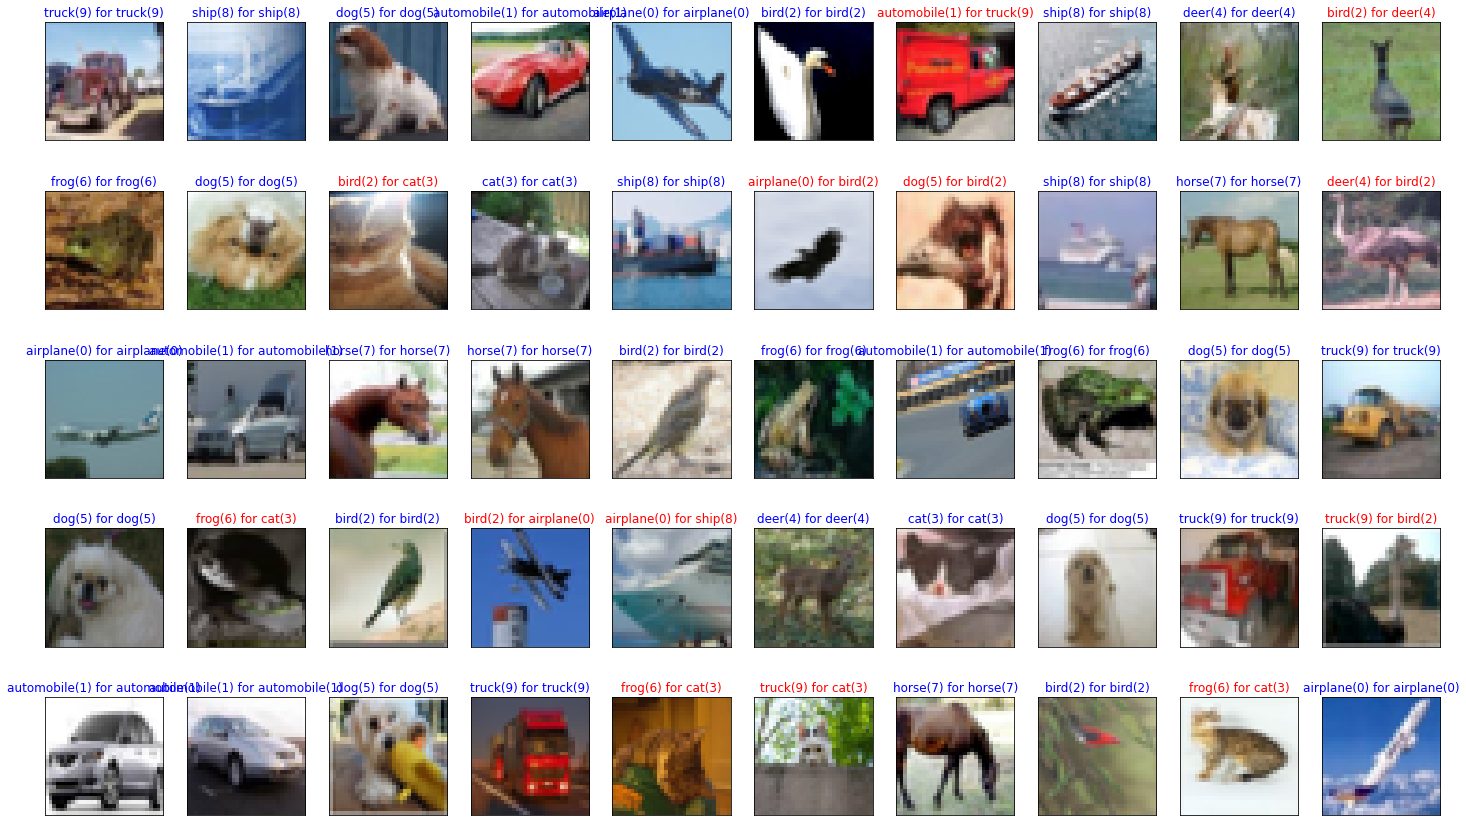

In [18]:
test(model)